In [2]:
# importing libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import networkx as nx 
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from ema_workbench import (Model, RealParameter, IntegerParameter, CategoricalParameter, ScalarOutcome, TimeSeriesOutcome)
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging
from ema_workbench.analysis import prim
from ema_workbench.analysis import dimensional_stacking
from ema_workbench.analysis import feature_scoring
from ema_workbench import save_results
from ema_workbench import load_results
from ema_workbench.analysis import plotting, plotting_util


C:\Users\fuukv\anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
C:\Users\fuukv\anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\fuukv\anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)


In [3]:
#model imports
from LivModel_SIR import LivModel_SIR
from LivAgent import LivAgent
from LivGovt import LocalGovt
from LivHazard import HazardAgent
from LivAid import AidWorker
import statistics as stats
import market as mrkt
import household as hsh
import shelter as shelter
import hospital as hosp

In [3]:
# policy interventions
p0 = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 8, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': False, 'height_cash': 0}

#priority
p1a = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': True, 'cash_transfer_policy': False, 'height_cash': 0}

p1b = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': False, 'height_cash': 0}

#awareness + effect awareness
p2a = {'awareness_policy': True, 'awareness_effect': 0.01, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': False, 'height_cash': 0}
p2b = {'awareness_policy': True, 'awareness_effect': 0.1, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': False, 'height_cash': 0}

#shelters
p3a = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 0.1,
     'corona_prioritization': False, 'cash_transfer_policy': False, 'height_cash': 0}
p3b = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 0.05,
     'corona_prioritization': False, 'cash_transfer_policy': False, 'height_cash': 0}

#cash transfer
p4a = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': True, 'height_cash': 7}

p4b = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': True, 'height_cash': 14}


p4c = {'awareness_policy': False, 'awareness_effect': 0, 'num_shelters': 10, 'shelter_frac': 1,
     'corona_prioritization': False, 'cash_transfer_policy': True, 'height_cash': 21}


p = p0

In [4]:
seed1 = 44
#np.random.seed(seed1)

#steering board
initial_live = 2 #round(random.uniform(1,10)) #initial livelihood
check = 0
num_aidworkers = 0
num_agents = 1000 + num_aidworkers #population size
E0 = 10 #initial number of exposed people
A0 = 0

#exposure_threshold = 6.5 
livelihood_threshold = 5

#switches
corona_switch = True
testing_switch = True #include or exclude testing from the model
livelihood_switch = True
hazard_switch = True

#model variables
test_frequency = 3 #test every 3 days
market_capacity = 0.8 #max cap is 80% of population
population_density = 0.15 #on average households of 7/8 people
shelter_density = 0.001 #shelters per population based on 6 shelters for 6000 people

#corona settings
#corona_threshold = False #if false, corona is ok
corona_fraction = 0.1 #absolute cases of corona before lockdown becomes more strict
growth_threshold = 10 #if more than 10 percent change of corona cases, lockdown is needed
ptrans = 0.1
precov = 1/14

#policy interventions
# awareness_policy = True
# awareness_effect = 0.1
# corona_prioritization = False
# height_cash = 7
# cash_transfer_policy = False
# num_shelters = 10
# shelter_frac = 0.05

#contact rates at market
shelter_perc_meeting = 0.2 #you meet 20% of people staying at shelter?
min_contacts = [1,2,3]
med_contacts = [2,3,4]
max_contacts = [3,4,5]
max_contacts_shelter = [5,6,7,8,9,10]

#livelihood settings
max_farm_liv_open = 1.5
max_farm_liv_closed = 0.5
min_farm_liv_open = 1
min_farm_liv_closed = 0.5

max_cit_liv_open = 3
max_cit_liv_closed = 1
min_cit_liv_open = 2
min_cit_liv_closed = 1

decrease_liv_aid = -1.0
decrease_liv_mask = -0.5

shelter_time = random.randint(3,30) #number of days people have to evacuate before they are to return home
isolation_duration = 14 #need 14 days in isolation when getting corona


In [5]:
def LivModel(seed = seed1, width = 50, height = 50, initial_live = initial_live, check = 0, num_agents = num_agents, corona_threshold = False,
                 growth_threshold = growth_threshold, corona_fraction = corona_fraction, E0 = E0, shelter_frac = p['shelter_frac'], A0 = A0, awareness_policy = p['awareness_policy'], awareness_effect = p['awareness_effect'],
                 livelihood_threshold = livelihood_threshold, corona_switch = corona_switch, hazard_switch = hazard_switch, livelihood_switch = livelihood_switch,
                 num_aidworkers = num_aidworkers, testing_switch = testing_switch, test_frequency = test_frequency,
                 market_capacity = market_capacity, min_contacts = min_contacts, med_contacts = med_contacts, max_contacts = max_contacts, 
                 population_density = population_density, shelter_density = shelter_density, max_farm_liv_closed = max_farm_liv_closed,
                 min_farm_liv_closed = min_farm_liv_closed, max_cit_liv_closed = max_cit_liv_closed, min_cit_liv_closed = min_cit_liv_closed, max_farm_liv_open = max_farm_liv_open,
                 min_farm_liv_open = min_farm_liv_open, max_cit_liv_open = max_cit_liv_open, min_cit_liv_open = min_cit_liv_open, isolation_duration = isolation_duration,
                 decrease_liv_aid = decrease_liv_aid, decrease_liv_mask = decrease_liv_mask, ptrans = ptrans, precov = precov, num_shelters = p['num_shelters'], cash_transfer_policy = p['cash_transfer_policy'],
                 corona_prioritization = p['corona_prioritization'], height_cash = p['height_cash'], max_contacts_shelter = max_contacts_shelter, steps = 40,
                shelter_perc_meeting = shelter_perc_meeting):
    
    model = LivModel_SIR(seed, width, height, initial_live, check, num_agents, corona_threshold,
                 growth_threshold, corona_fraction, E0, shelter_frac, A0, awareness_policy, awareness_effect,
                 livelihood_threshold, corona_switch, hazard_switch, livelihood_switch, num_aidworkers, testing_switch, test_frequency,
                 market_capacity, min_contacts, med_contacts, max_contacts, population_density, shelter_density, max_farm_liv_closed,
                 min_farm_liv_closed, max_cit_liv_closed, min_cit_liv_closed, max_farm_liv_open,
                 min_farm_liv_open, max_cit_liv_open, min_cit_liv_open, isolation_duration,
                 decrease_liv_aid, decrease_liv_mask, ptrans, precov, num_shelters, cash_transfer_policy,
                 corona_prioritization, height_cash, max_contacts_shelter, shelter_perc_meeting)
    
    # run the model for 40 steps
    model.run_model()
    data = model.datacollector.get_model_vars_dataframe().reset_index()
    
    return data


In [6]:
model = Model('livmodel', function = LivModel)

model.uncertainties = [IntegerParameter('min_contacts', 1, 2),
                      IntegerParameter('med_contacts', 2, 3),
                      IntegerParameter('max_contacts', 3, 4),
                      IntegerParameter('max_contacts_shelter', 5, 15),
                       IntegerParameter("initial_live", 1, 5)
                    
                       #POLICY UNCERTAINTIES for LOCKDOWN
#                       RealParameter('corona_fraction', 0.01, 0.2),
#                       IntegerParameter('growth_threshold', 1, 15),
#                       IntegerParameter('livelihood_threshold', 1, 10)
                       
                       #POLICY UNCERTAINTIES FOR AWARENESS
                       #IntegerParameter('A0', 10, 100)
                       
                       #POLICY UNCERTAINTIES FOR SHELTERS
                       
                       #POLICY UNCERTAINTIES FOR CASH TRANSFER
                      ]

model.outcomes = [TimeSeriesOutcome('Infected'),
                  TimeSeriesOutcome('Susceptible'),
                  TimeSeriesOutcome('Exposed'),
                  TimeSeriesOutcome('Recovered'),
                  TimeSeriesOutcome('Avg_livelihood'),
                  TimeSeriesOutcome('total_sheltered_agents'),
                  TimeSeriesOutcome('affected_agents'),
                  TimeSeriesOutcome('total_unsheltered_agents'),
                  TimeSeriesOutcome('low_liv_counter'),
                  TimeSeriesOutcome('Shelter_time'),
                  TimeSeriesOutcome('warning'),
                  TimeSeriesOutcome('shelter_pop'),
                  ]

## Experimentation

In [7]:
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 1000

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios)

In [10]:
results = experiments, outcomes
save_results(results, 'Results_p0_nov24.tar.gz')

In [15]:
# # load all data
# experiments0, outcomes0 = load_results('Results_p0_nov24.tar.gz')
# experiments1a, outcomes1a = load_results('Results_p5a.tar.gz')
# experiments1b, outcomes1b = load_results('Results_p5b.tar.gz')
# experiments2a, outcomes2a = load_results('Results_p2a_jannew.tar.gz')
# experiments2b, outcomes2b = load_results('Results_p2b_jannew.tar.gz')

# experiments3a, outcomes3a = load_results('Results_shelter_policy_randomsev_shelter_implemented.tar.gz')
# experiments3b, outcomes3b = load_results('Results_shelter_policy_fixed_sev_shelter_implemented.tar.gz')
# experiments3c, outcomes3c = load_results('Results_p3a_cash_transfer_continuous.tar.gz')

# experiments4a, outcomes4a = load_results('Results_p4a_nov24.tar.gz')
# experiments4b, outcomes4b = load_results('Results_p4b_nov24.tar.gz')
# experiments4c, outcomes4c = load_results('Results_p4c_nov24.tar.gz')



### More kpis

In [16]:
#total area under graph infections
total_inf_0 = []
total_inf_1a = []
total_inf_1b = []
total_inf_2a = []
total_inf_2b = []
total_inf_3a = []
total_inf_3b = []
total_inf_3c = []
total_inf_4a = []
total_inf_4b = []
total_inf_4c = []
outcomes0["Infected"][0].sum()
for i in range(1000):
    total_inf_0.append(outcomes0["Infected"][i].sum())
    total_inf_1a.append(outcomes1a["Infected"][i].sum())
    total_inf_1b.append(outcomes1b["Infected"][i].sum())
    total_inf_2a.append(outcomes2a["Infected"][i].sum())
    total_inf_2b.append(outcomes2b["Infected"][i].sum())
    total_inf_3a.append(outcomes3a["Infected"][i].sum())
    total_inf_3b.append(outcomes3b["Infected"][i].sum())
    total_inf_3c.append(outcomes3c["Infected"][i].sum())
    total_inf_4a.append(outcomes4a["Infected"][i].sum())
    total_inf_4b.append(outcomes4b["Infected"][i].sum())
    total_inf_4c.append(outcomes4c["Infected"][i].sum())


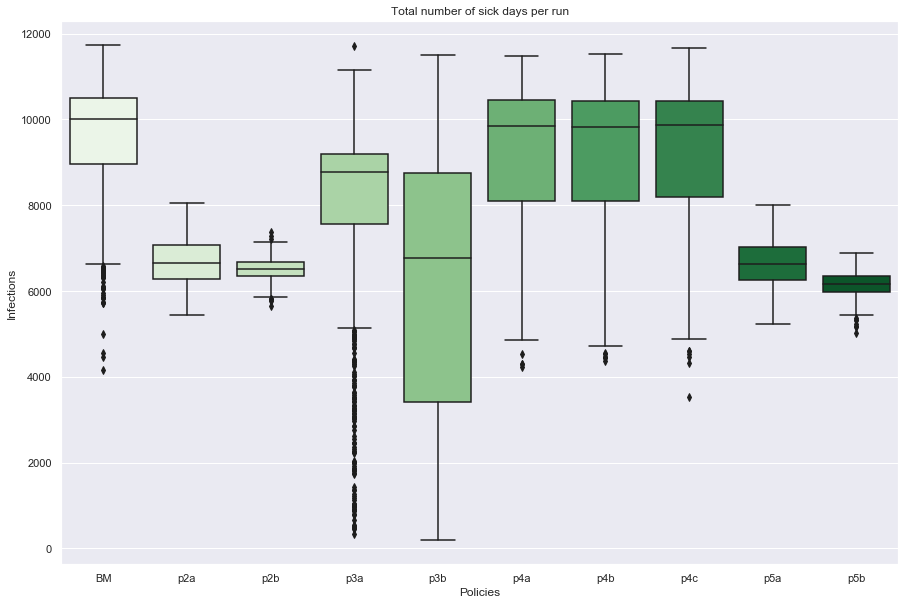

In [26]:
# creating boxplots to compare interventions based on the KPIs
sns.boxplot(x = ['BM', 'p2a', 'p2b', 'p3a', 'p3b', 'p4a', 'p4b','p4c', 'p5a', 'p5b',], 
            y=[ total_inf_0, 
                total_inf_2a,total_inf_2b ,
               total_inf_3a,total_inf_3b ,
               total_inf_4a,total_inf_4b,total_inf_4c,
              total_inf_1a ,total_inf_1b], 
            palette = 'Greens')
sns.set(rc={'figure.figsize':(15,10)})
plt.ylabel('Infections')
plt.xlabel('Policies')
plt.title("Total number of sick days per run")

plt.show()

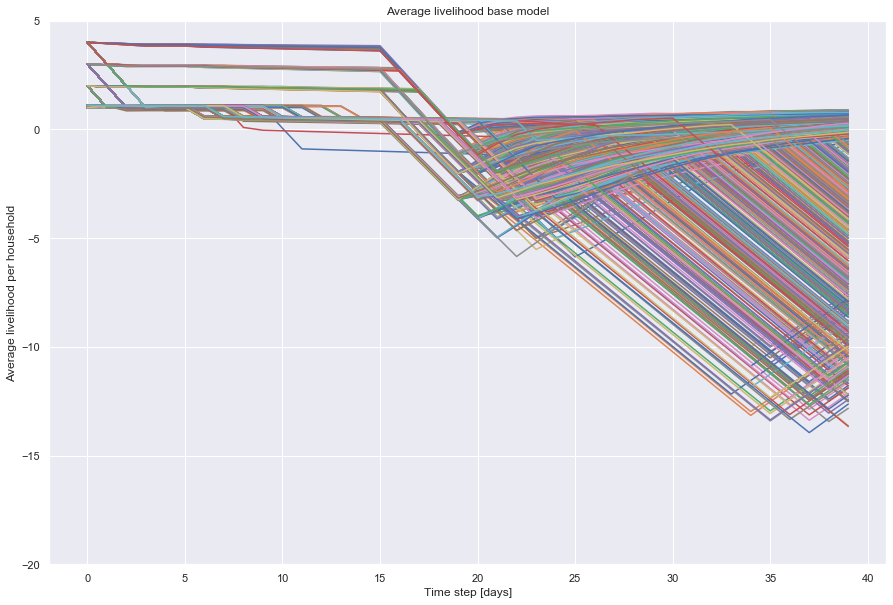

In [14]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes0.keys():
    if outcome == 'Avg_livelihood':
        plotting.lines(experiments0, outcomes0, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Average livelihood per household')
plt.title("Average livelihood base model")
plt.ylim(-20, 5)
plt.show()

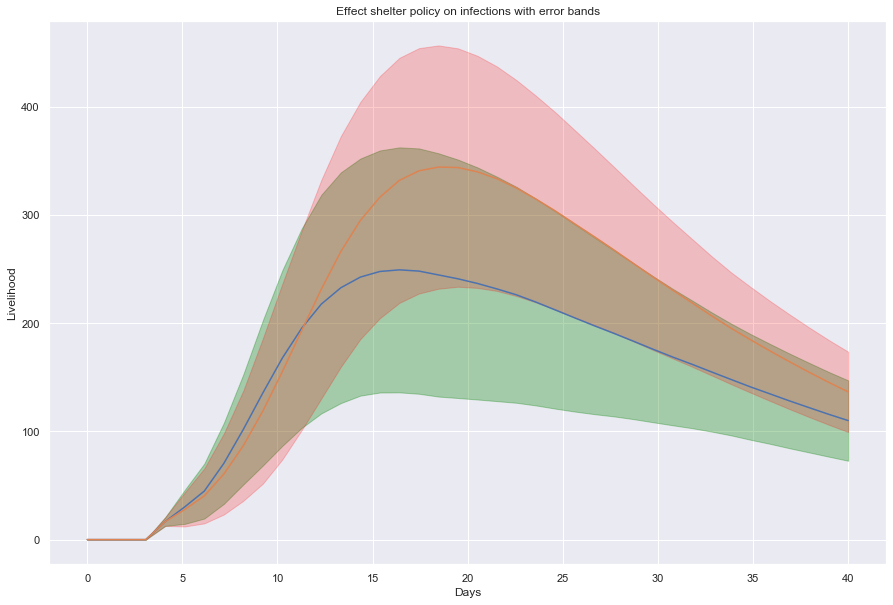

In [18]:
x = np.linspace(0, 40, 40)
y = df.loc["mean"]
z = df2.loc["mean"]
error = df.loc["error"]
errorz = df2.loc["error"]

plt.plot(x, z, '-')
plt.fill_between(x, z-error, z+error, alpha = 0.3, color = "green")
plt.plot(x, y, '-')
plt.fill_between(x, y-error, y+error, alpha = 0.2, color = "red")
plt.title("Effect shelter policy on infections with error bands")
plt.xlabel("Days")
plt.ylabel("Livelihood")
plt.show()

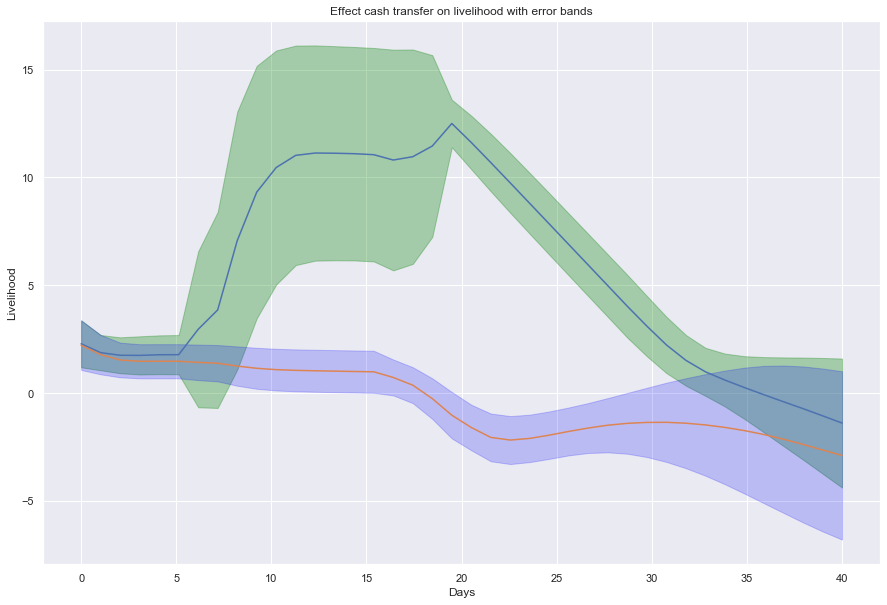

In [21]:
x = np.linspace(0, 40, 40)
y = df.loc["mean"]
z = df2.loc["mean"]
k = df3.loc["mean"]
error = df.loc["error"]
errorz = df2.loc["error"]
errork = df3.loc["error"]

plt.plot(x, z, '-')
plt.fill_between(x, z-errorz, z+errorz, alpha = 0.3, color = "green")
# plt.plot(x, y, '-')
# plt.fill_between(x, y-error, y+error, alpha = 0.2, color = "red")
plt.plot(x,k,'-')
plt.fill_between(x, k-errork, k+errork, alpha = 0.2, color = "blue")

plt.title("Effect cash transfer on livelihood with error bands")
plt.xlabel("Days")
plt.ylabel("Livelihood")
plt.show()

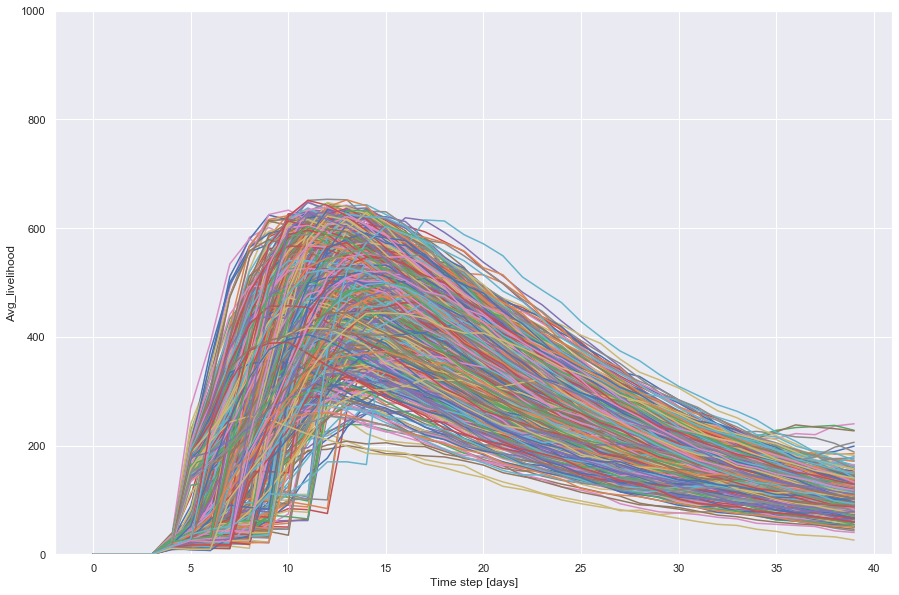

In [23]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes0.keys():
    if outcome == 'Infected':
        plotting.lines(experiments0, outcomes0, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Avg_livelihood')
plt.ylim(0, 1000)
plt.show()

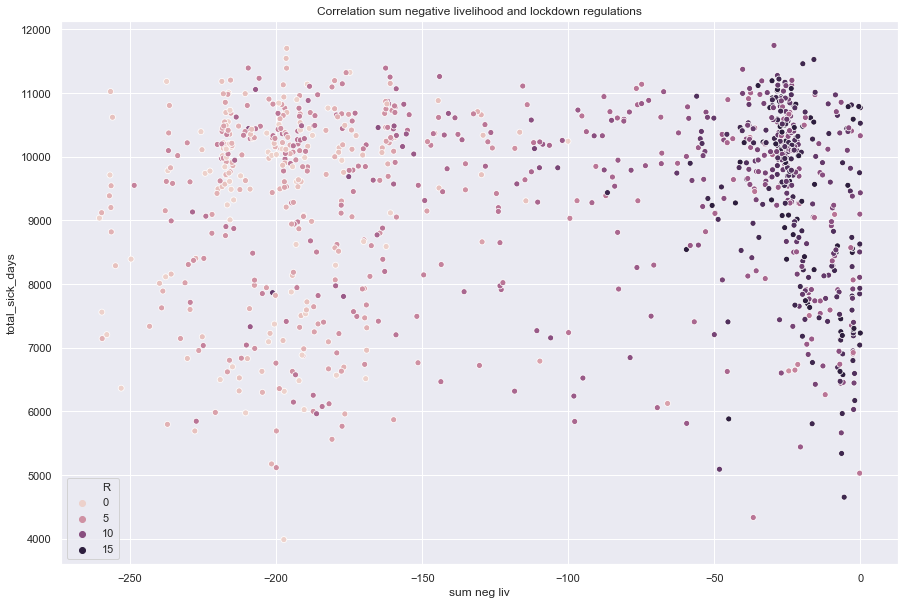

In [28]:
#What you see: max infected runs in relation to the size of the shelter in relation to the number of shelters
sns.scatterplot(data=x, x="sum neg liv", y="total_sick_days", hue ="R")
sns.set(rc={'figure.figsize':(15,10)})
plt.title("Correlation sum negative livelihood and lockdown regulations")
plt.show()

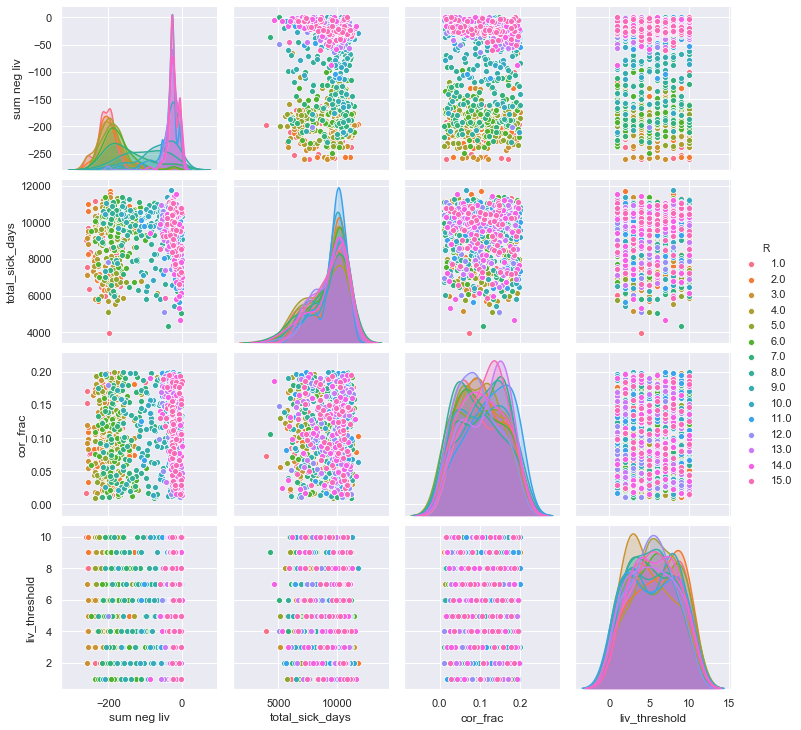

In [30]:
sns.pairplot(x, hue="R")

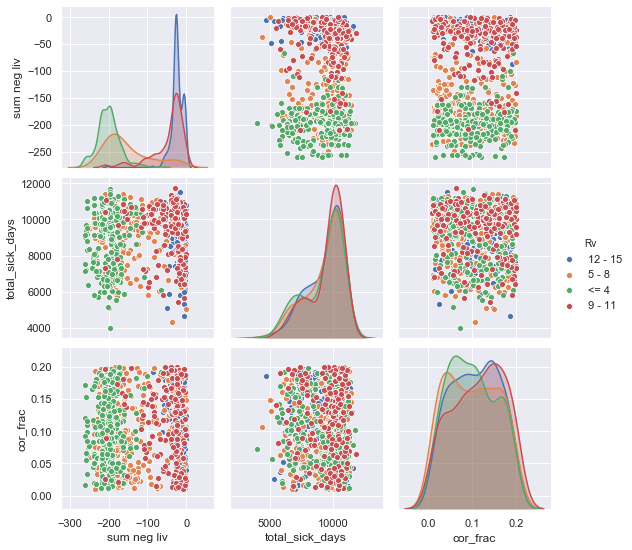

In [31]:
xx = x[["sum neg liv", "total_sick_days", "cor_frac", "Rv"]]
sns.pairplot(xx, hue="Rv")
#plt.title("Pairplot growth_threshold, total infected days and negative livelihood")

In [32]:
# check the range of infections per policy scenario

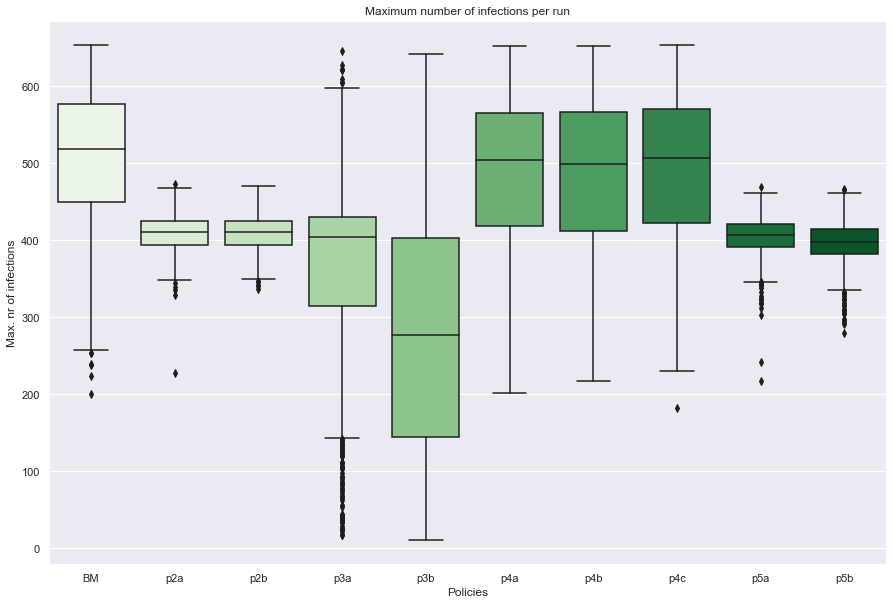

In [17]:
# creating boxplots to compare interventions based on the KPIs
sns.boxplot(x = ['BM','p2a', 'p2b', 'p3a', 'p3b', 'p4a', 'p4b','p4c', 'p5a', 'p5b'], 
            y=[outcomes0["Infected"][np.arange(len(outcomes0["Infected"])), np.argmax(outcomes0["Infected"], axis=1)]  , 
               outcomes2a["Infected"][np.arange(len(outcomes2a["Infected"])), np.argmax(outcomes2a["Infected"], axis=1)]  ,
               outcomes2b["Infected"][np.arange(len(outcomes2b["Infected"])), np.argmax(outcomes2b["Infected"], axis=1)]  ,
               outcomes3a["Infected"][np.arange(len(outcomes3a["Infected"])), np.argmax(outcomes3a["Infected"], axis=1)],  
               outcomes3b["Infected"][np.arange(len(outcomes3b["Infected"])), np.argmax(outcomes3b["Infected"], axis=1)] , 
               outcomes4a["Infected"][np.arange(len(outcomes4a["Infected"])), np.argmax(outcomes4a["Infected"], axis=1)]  ,
               outcomes4b["Infected"][np.arange(len(outcomes4b["Infected"])), np.argmax(outcomes4b["Infected"], axis=1)] ,
              outcomes4c["Infected"][np.arange(len(outcomes4c["Infected"])), np.argmax(outcomes4c["Infected"], axis=1)] ,
            outcomes1a["Infected"][np.arange(len(outcomes1a["Infected"])), np.argmax(outcomes1a["Infected"], axis=1)]  ,
               outcomes1b["Infected"][np.arange(len(outcomes1b["Infected"])), np.argmax(outcomes1b["Infected"], axis=1)]  ], 
            palette = 'Greens')
sns.set(rc={'figure.figsize':(15,10)})
plt.ylabel('Max. nr of infections')
plt.xlabel('Policies')
plt.title("Maximum number of infections per run")
plt.show()

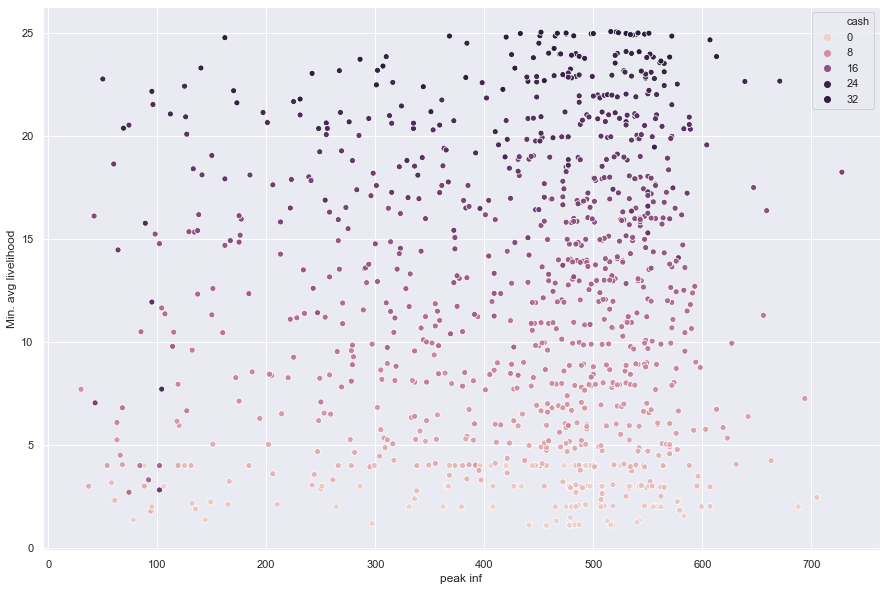

In [75]:
sns.scatterplot(data=d, x="peak inf", y="Min. avg livelihood", hue ="cash")

In [ ]:
#PRIMPRIMPRIMROSEEVERDEEN

In [92]:
del outcomes0["shelter_pop"]

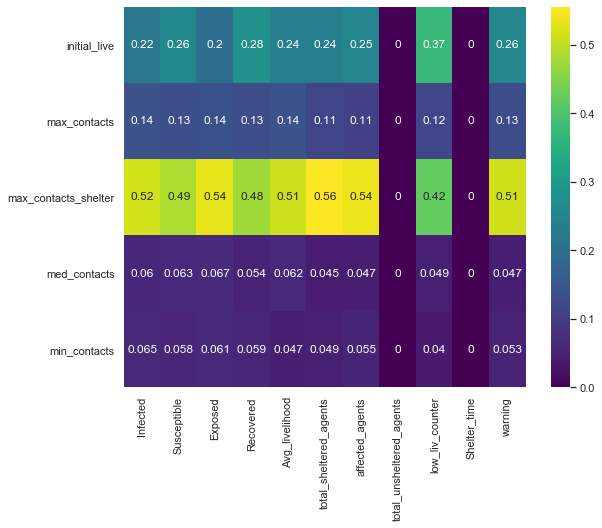

In [93]:
fig, ax = plt.subplots(figsize=(9,7))  
scores = feature_scoring.get_feature_scores_all(experiments0, outcomes0)
sns.heatmap(scores, cmap='viridis', annot=True, ax=ax)
plt.show()

In [ ]:
# plotting the adoption curves - here: for cash-transfer-only (p1)
from ema_workbench.analysis import plotting, plotting_util

for outcome in outcomes0.keys():
    if outcome == 'Avg_livelihood':
        plotting.lines(experiments0, outcomes0, titles = None, outcomes_to_show=outcome)

plt.xlabel('Time step [days]')
plt.ylabel('Avg_livelihood')
plt.ylim(-20, 10)
plt.show()

In [ ]:
# define outcomes of interest
# PRIM for p4 with shocks
liv = outcomes0['Avg_livelihood']
#select indices where livelihood were min
min_livelihood = liv[np.arange(len(liv)), np.argmin(liv, axis=1)]
y = min_livelihood < np.percentile(min_livelihood, 25) #25 is TRUE

# apply PRIM algorithm to map outcomes of interest to sub-spaces in uncertainty space (scenarios)
prim_alg = prim.Prim(experiments0, y, threshold=0.55, peel_alpha = 0.01)
box1 = prim_alg.find_box()

In [ ]:
# plotting the parameter ranges found by PRIM
box1.inspect(style='graph')
plt.show()

In [ ]:
box1.show_tradeoff()
plt.show()